In [2]:
import re
import os
import cv2
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from PIL import Image

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random
import torch
from PIL import Image
import requests

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2


Segmentation Models: using `keras` framework.


In [3]:
#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val/'
path_images_resized = 'rs19_val/images_resized/'
path_masks = 'rs19_val/uint8/rs19_val/'
path_masks_resized = 'rs19_val/masks_resized/'


# read the tram list and turn it into a dict
tram_list = pd.read_csv('tram_filenames.csv')
tram_dict = tram_list.iloc[:,1:].to_dict()

# Creation of the dataset for training

- Create dataset for original images as well as masks
- Create dataset for resized images and resized masks (with label of interest and all labels)
- process the resized image to generate a mask with a region of interest
- prepare the final output mask with veg masks only in the region of interest

In [39]:
label_of_interest=8

image_dataset_resized = []

mask_poly=[]

canny_edge_image_with_lines=[]

masked_dataset_resized = []

masked_veg_roi=[]

for i in range(200):
    image_resized = mpimg.imread(path_images_resized+tram_dict['filename_jpg'][i])  #Read each image as BGR
    mask_resized = mpimg.imread(path_masks_resized+tram_dict['filename_mask'][i])

        # VEG-FOCUSED mask
    #mask_resized[mask_resized!=label_of_interest]=0
    #mask_resized[mask_resized==label_of_interest]=1

    image_dataset_resized.append(image_resized)
    masked_dataset_resized.append(mask_resized)
            
    # start pre-processing for canny edge detection
    gray = cv2.cvtColor(np.array(image_resized),cv2.COLOR_RGB2GRAY)
    ## Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    # Define our parameters for Canny and run it
    low_threshold = 180
    high_threshold = 240
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Display the image
    #plt.imshow(edges, cmap='Greys_r')
    #plt.title("Canny Edge Detection Image")
    #plt.show()
    # Next we'll create a masked edges image using cv2.fillPoly(o)
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    # This time we are defining a four sided polygon to mask
    imshape = np.array(image_resized).shape
    #vertices = np.array([[(0,imshape[0]),(120, 150), (135, 150), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(0,imshape[0]),(130, 150), (130, 150), (imshape[1],imshape[0])]], dtype=np.int32)
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    mask_poly.append(mask)
   
   
    masked_edges = cv2.bitwise_and(edges, mask)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 2     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 4 #minimum number of pixels making up a line
    max_line_gap = 5    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image_resized)*0 # creating a blank to draw lines on
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

    if lines is not None:
    # Iterate over the output "lines" and draw lines on a blank image
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    lines_edges = cv2.polylines(lines_edges,vertices, True, (0,0,255), 10)
    canny_edge_image_with_lines.append(lines_edges)
    cv2.imwrite('rs19_val/lines_edges/'+tram_dict['filename_mask'][i]+'.png', lines_edges)

    # multiply the resized mask with canny edge image containing lines for roi
    dataset_mask_multiplied = mask_resized * mask
    #dataset_mask_multiplied[dataset_mask_multiplied!=0]=8
    masked_veg_roi.append(dataset_mask_multiplied)
    cv2.imwrite('rs19_val/mask_veg_roi/'+tram_dict['filename_mask'][i]+'.png', dataset_mask_multiplied)



image_dataset_resized = np.array(image_dataset_resized)
mask_dataset_resized = np.array(masked_dataset_resized)
canny_edge_image_with_lines=np.array(canny_edge_image_with_lines)
masked_veg_roi=np.array(masked_veg_roi)


#pickle.dump(image_dataset_resized, open('image_dataset_resized_10', "wb"))
#pickle.dump(mask_dataset_resized, open('mask_dataset_10', "wb"))
#pickle.dump(dataset_mask_multiplied, open('dataset_roi_mask_10', "wb"))

print(image_resized.shape)
print(mask_resized.shape)
print(image_dataset_resized.shape)
print(mask_dataset_resized.shape)
print(masked_veg_roi.shape)

(256, 256, 3)
(256, 256)
(200, 256, 256, 3)
(200, 256, 256)
(200, 256, 256)


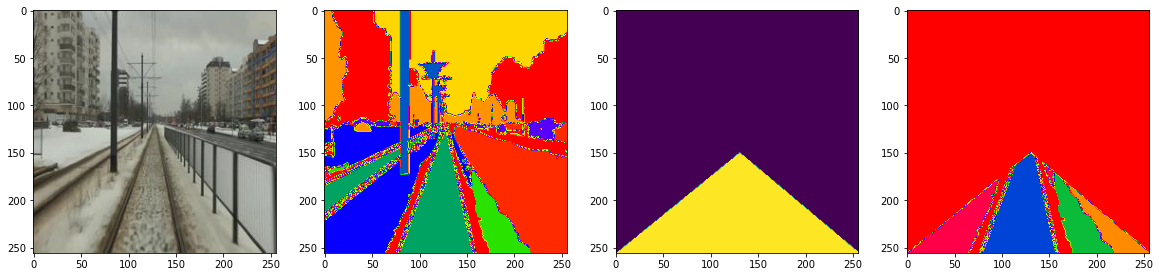

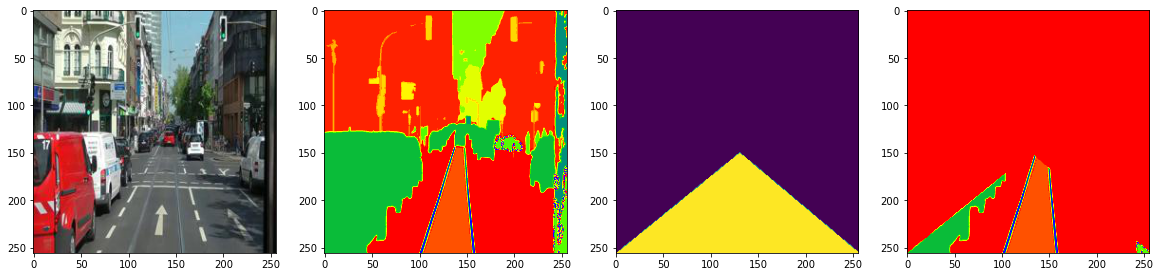

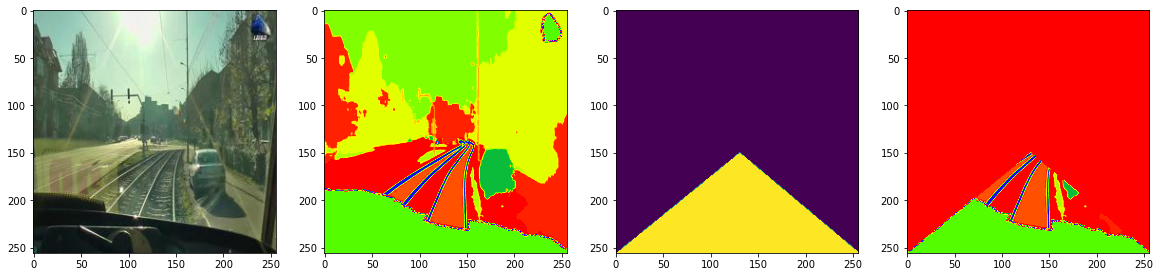

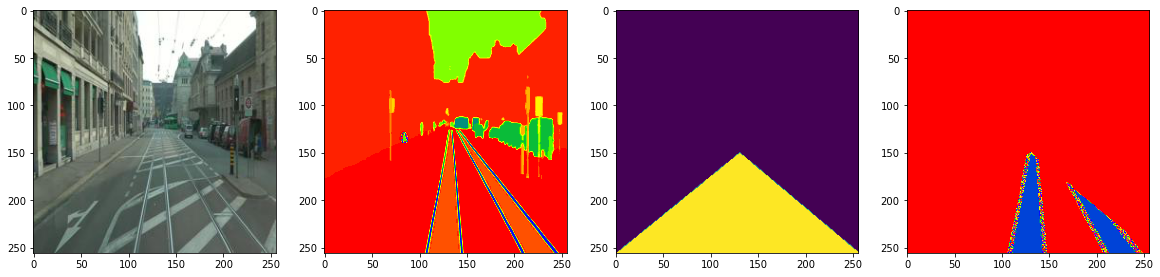

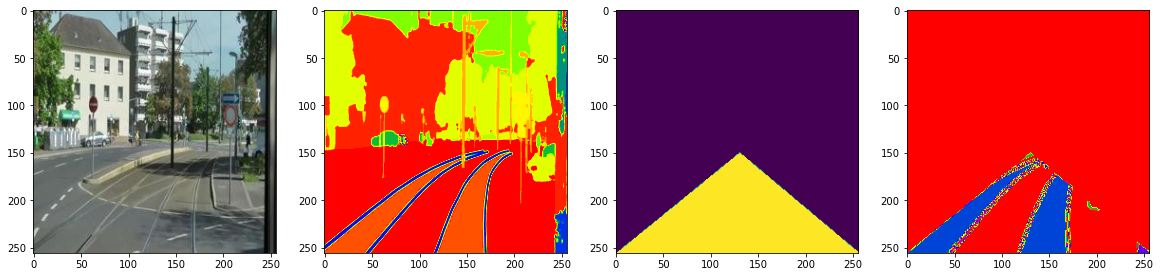

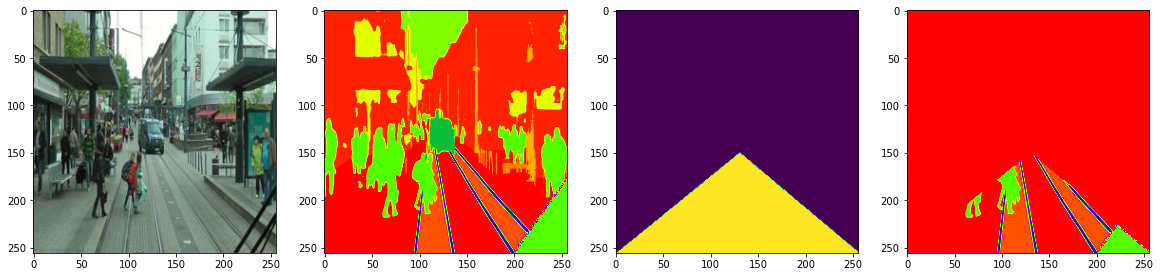

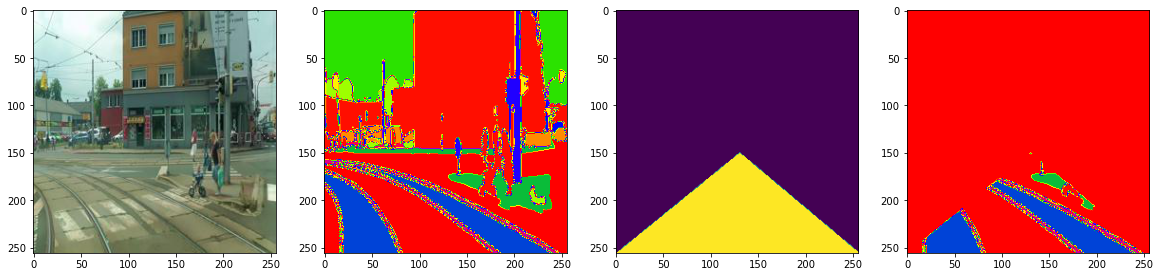

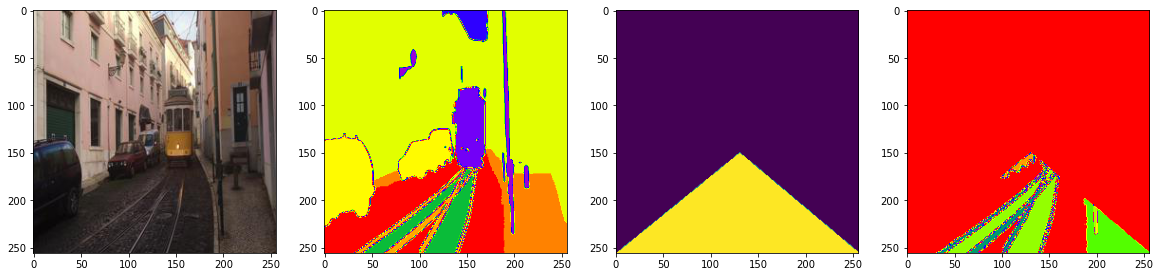

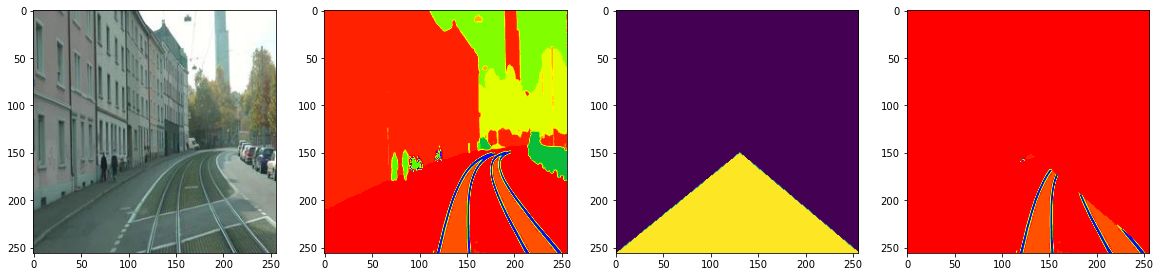

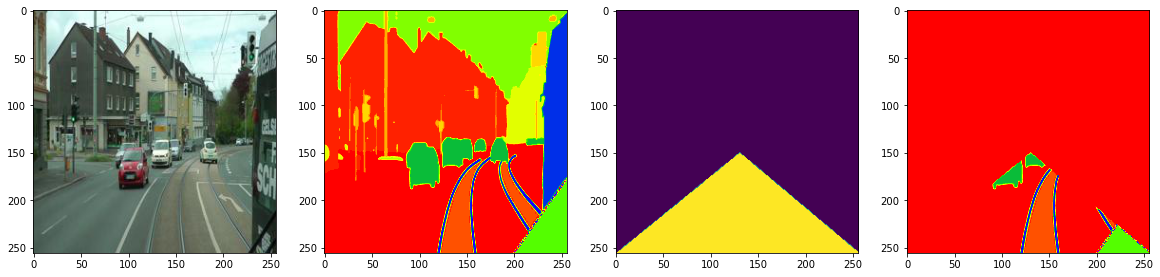

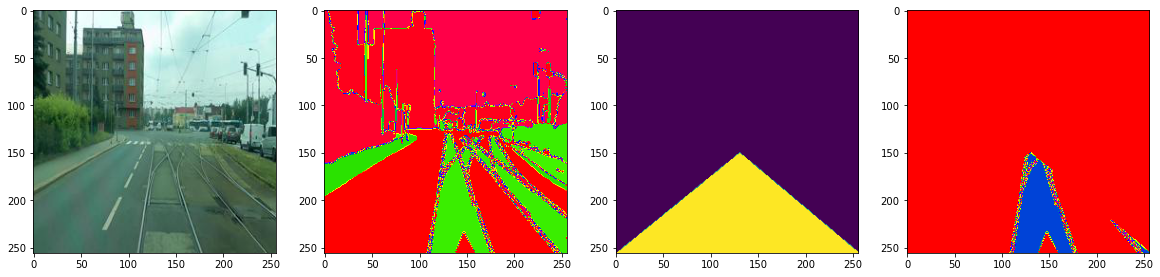

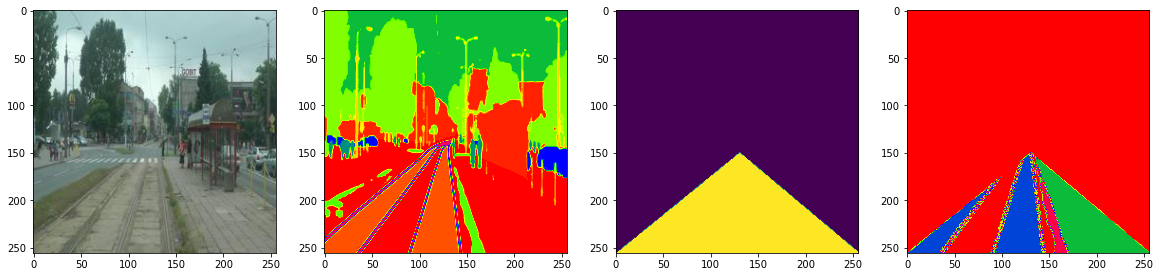

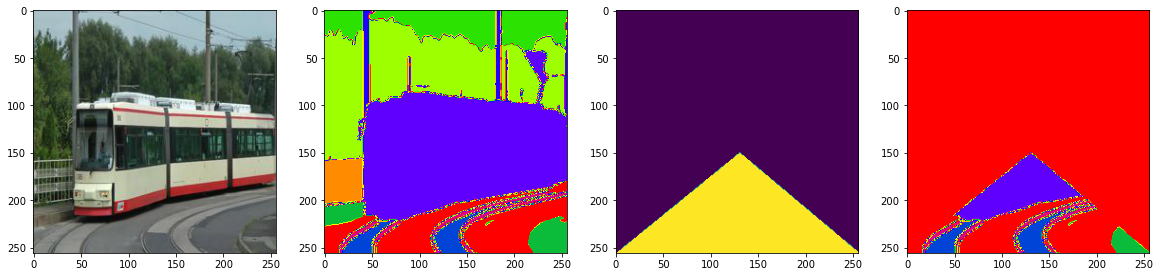

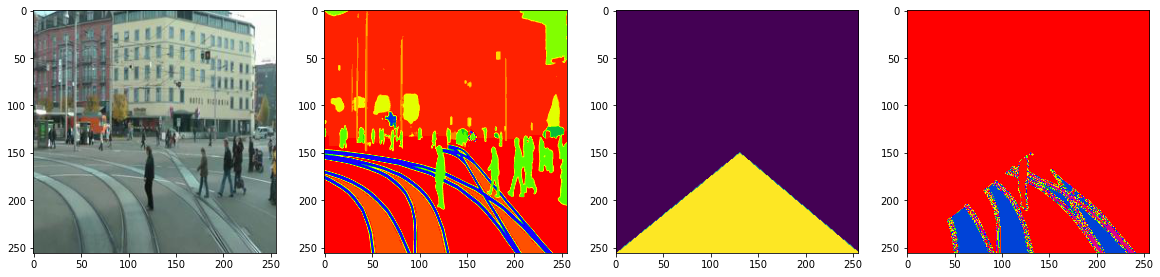

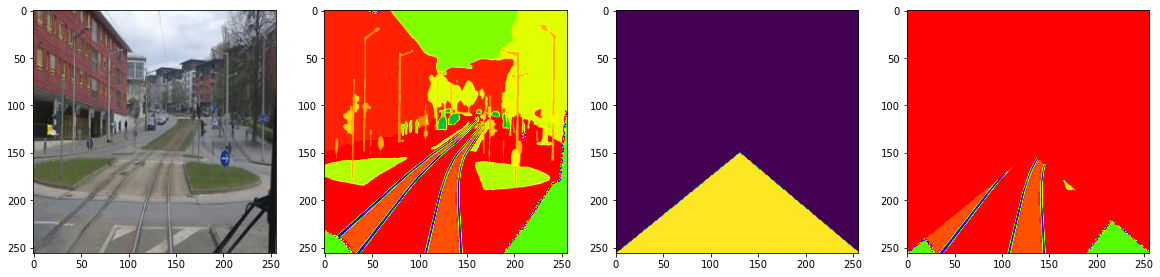

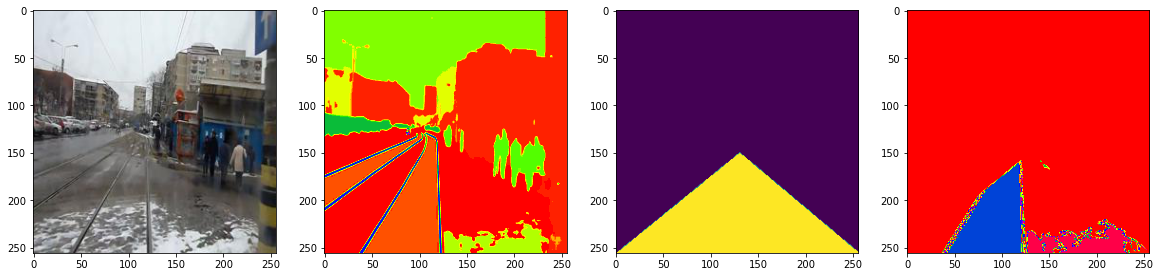

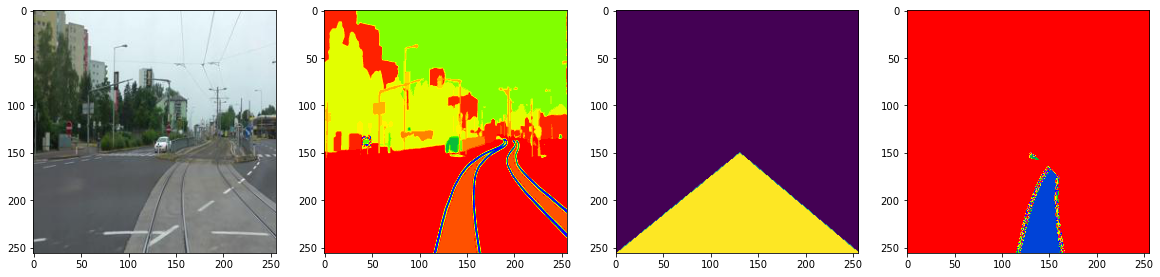

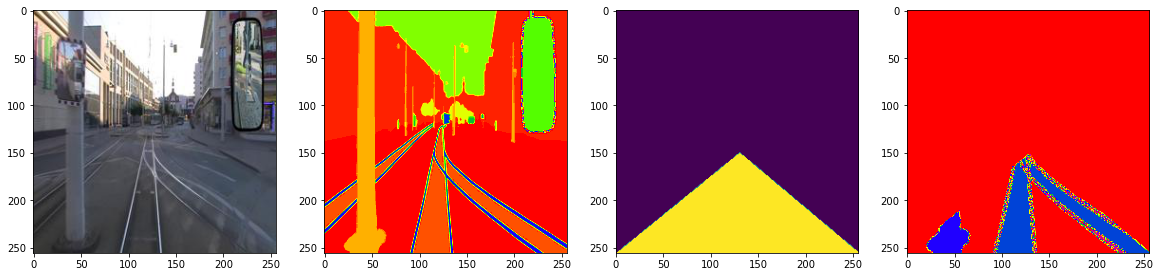

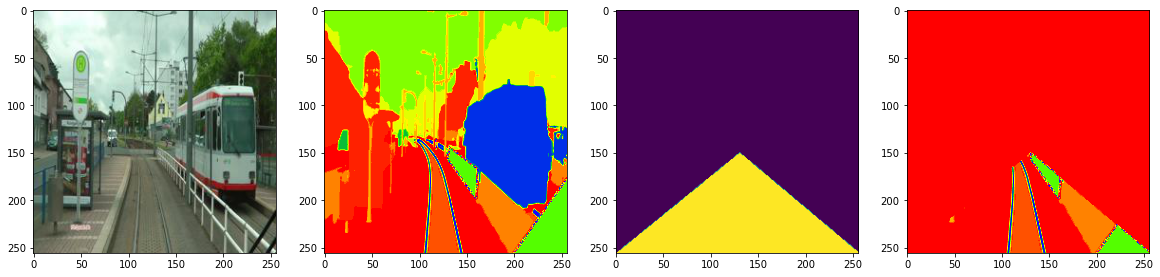

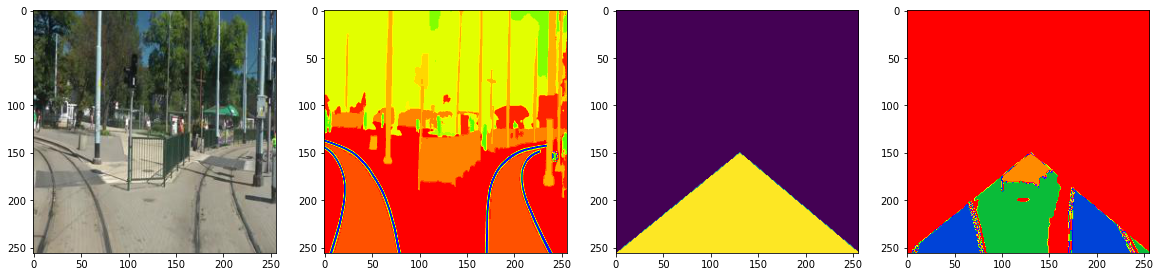

In [38]:
for index in range (20):
    figure, axis_arr = plt.subplots(1,4, figsize=(20,20)) 
    axis_arr[0].imshow(image_dataset_resized[index])
    axis_arr[1].imshow(masked_dataset_resized[index], cmap='prism')
    axis_arr[2].imshow(mask_poly[index])
    axis_arr[3].imshow(masked_veg_roi[index], cmap='prism')

In [26]:
mask_dataset_resized[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)